### EDA Flights

additional space for completing EDA on flights data

---
**INPUT**: flights with nulls removed

---

In [2]:
#import packages
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as st

In [ ]:
df = pd.read_csv("flight_sample_small.csv")

In [3]:
df = pd.read_csv("flight_sample_large.csv")

In [5]:
df.head()

,fl_date,mkt_unique_carrier,branded_code_share,mkt_carrier,mkt_carrier_fl_num,op_unique_carrier,tail_num,op_carrier_fl_num,origin_airport_id,origin,...,flights,distance,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay,first_dep_time,total_add_gtime,longest_add_gtime
0,2019-01-11,AS,AS,AS,64,AS,N611AS,64,15841,WRG,...,1.0,82.0,0.0,0.0,0.0,0.0,0.0,1620.0,0.0,0.0
1,2018-01-21,AA,AA_CODESHARE,AA,5206,OH,N587NN,5206,13577,MYR,...,1.0,157.0,0.0,0.0,0.0,0.0,0.0,922.0,0.0,0.0
2,2019-12-22,DL,DL_CODESHARE,DL,4861,9E,N478PX,4861,14576,ROC,...,1.0,783.0,0.0,0.0,0.0,0.0,0.0,606.0,0.0,0.0
3,2019-01-11,WN,WN,WN,1572,WN,N404WN,1572,14683,SAT,...,1.0,247.0,0.0,0.0,0.0,0.0,0.0,825.0,0.0,0.0
4,2018-11-30,WN,WN,WN,1006,WN,N906WN,1006,14679,SAN,...,1.0,853.0,0.0,0.0,0.0,0.0,0.0,1240.0,0.0,0.0


---

Q: What information is the tail_num providing <br>
A: When combined with date we can determine how many trips a single plane makes

Expectations: planes that make more than 1 trip in a day are more likely to have a net delay
<br>True

---

In [3]:
tail = df[df.tail_num != "EMPTY"]
tail = tail.groupby(["tail_num", "fl_date"], as_index=False).arr_delay.count()
tail.rename(columns={"arr_delay": "num_of_arr"}, inplace=True)
tail2 = df.groupby(["tail_num", "fl_date"], as_index=False).arr_delay.sum()
tail2.rename(columns={"arr_delay": "net_arr_delay"}, inplace=True)
tail = tail.merge(tail2, on = ["tail_num", "fl_date"])

In [4]:
tailmultiple = tail[tail.num_of_arr > 1]
tailsingle = tail[tail.num_of_arr <= 1]

In [5]:
print("the average net arrival delay for planes making more than one trip per day is: ",
     round(tailmultiple.net_arr_delay.mean(),2))
print("the average net arrival delay for planes making one trip per day is: ",
     round(tailsingle.net_arr_delay.mean(),2))

the average net arrival delay for planes making more than one trip per day is:  12.53
the average net arrival delay for planes making one trip per day is:  6.75


In [6]:
tails = tail.num_of_arr.unique()

In [18]:
netArrivalDelayMean = list(range(tails.max()))

In [37]:
for i in range(tails.max()):
    netArrivalDelayMean[i] = tail[tail.num_of_arr == i].net_arr_delay.mean()
arr_delay_mean_df = pd.DataFrame(netArrivalDelayMean)

In [38]:
arr_delay_mean_df.reset_index(inplace = True)
arr_delay_mean_df.rename(columns = {"index":"Number of Arrivals", 0:"net_arr_delay_mean"}, inplace=True)

In [42]:
arr_delay_mean_df.dropna(inplace=True)

In [48]:
arr_delay_mean_df['dA'] = arr_delay_mean_df['net_arr_delay_mean'] - arr_delay_mean_df['net_arr_delay_mean'].shift(1)

In [49]:
arr_delay_mean_df

,Number of Arrivals,net_arr_delay_mean,dA
1,1,6.747790,NaN
2,2,10.529565,3.781775
3,3,13.978261,3.448696
4,4,18.058546,4.080285
5,5,24.198052,6.139506
6,6,29.075430,4.877377
7,7,25.603837,-3.471592
8,8,31.207317,5.603480
9,9,16.214286,-14.993031
10,10,42.000000,25.785714


---

Q: What are the roles of the carriers? <br>
A: Providing infromation about flights for various levels of personel interactions<br>

Expectations: 
- code_share have higher delays
    - true

---

In [58]:
carriers = df[['fl_date', 'mkt_unique_carrier', 'branded_code_share', 'mkt_carrier',
       'mkt_carrier_fl_num', 'op_unique_carrier','op_carrier_fl_num','arr_delay']]

In [53]:
carriers.head()

,fl_date,mkt_unique_carrier,branded_code_share,mkt_carrier,mkt_carrier_fl_num,op_unique_carrier,arr_delay
0,2018-10-04,WN,WN,WN,1772,WN,-8.0
1,2019-02-18,DL,DL,DL,797,DL,-43.0
2,2019-08-21,AA,AA_CODESHARE,AA,3648,MQ,13.0
3,2019-08-29,AA,AA,AA,2409,AA,-7.0
4,2018-02-12,AS,AS,AS,39,AS,7.0


***Look at branded_code_share***

In [4]:
carriers_codeshare = carriers[['mkt_unique_carrier', 'branded_code_share', 'arr_delay']]

In [61]:
carriers_codeshare_g = carriers.groupby(['mkt_unique_carrier', 'branded_code_share'], as_index=False)["arr_delay"].mean()
carriers_codeshare_g.rename(columns={"arr_delay":"arr_delay_mean"}, inplace = True)

In [6]:
def check_codeshare(branded_codeshare):
    words = branded_codeshare.split("_")
    if len(words) == 2:
        return 1
    return 0

In [7]:
carriers_codeshare["is_codeshare"] = carriers_codeshare["branded_code_share"].map(check_codeshare)

<ipython-input-7-5927ff01643c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  carriers_codeshare["is_codeshare"] = carriers_codeshare["branded_code_share"].map(check_codeshare)


In [17]:
yescodeshare = carriers_codeshare[carriers_codeshare["is_codeshare"]==1].arr_delay
nocodeshare = carriers_codeshare[carriers_codeshare["is_codeshare"]==0].arr_delay

In [23]:
if len(yescodeshare) == len(nocodeshare):
    print("equal size")
elif len(yescodeshare) > len(nocodeshare):
    yescodeshare = yescodeshare.sample(len(nocodeshare))
    print("sample taken of yescodeshare")
else: 
    nocodeshare = nocodeshare.sample(len(nocodeshare))
    print("sample taken of nocodeshare")    

sample taken of nocodeshare


In [27]:
result = st.ttest_ind(yescodeshare,nocodeshare)

In [28]:
result[1]

0.0

***Mkt_unique_carrier vs mkt_carrier***

In [4]:
carriers.groupby("mkt_unique_carrier", as_index=False)["fl_date"].count()

,mkt_unique_carrier,fl_date
0,AA,1299724
1,AS,268190
2,B6,188410
3,DL,1093826
4,F9,80314
5,G4,62986
6,HA,55724
7,NK,119435
8,UA,972628
9,VX,5600


In [5]:
carriers.groupby("mkt_carrier", as_index=False)["fl_date"].count()

,mkt_carrier,fl_date
0,AA,1299724
1,AS,268190
2,B6,188410
3,DL,1093826
4,F9,80314
5,G4,62986
6,HA,55724
7,NK,119435
8,UA,972628
9,VX,5600


> Identical values lets drop one

***mkt_carrier_fl_num***

In [44]:
temp1 = carriers.groupby(["mkt_carrier","mkt_carrier_fl_num", "fl_date"], as_index=False)["arr_delay"].mean()
temp1.rename(columns = {"arr_delay": "mean_arr_delay"}, inplace=True)
temp = carriers.groupby(["mkt_carrier","mkt_carrier_fl_num", "fl_date"], as_index=False)["arr_delay"].count()
temp.rename(columns = {"arr_delay": "arrival_count"}, inplace=True)
temp = temp.merge(temp1, on=["mkt_carrier","mkt_carrier_fl_num", "fl_date"])

In [46]:
temp.sort_values(by="mean_arr_delay", ascending=False).head(30)

,mkt_carrier,mkt_carrier_fl_num,fl_date,arrival_count,mean_arr_delay
2641357,DL,6237,2019-11-21,1,2973.0
2855950,HA,466,2018-02-09,1,2454.0
2795516,G4,1756,2019-11-26,1,1966.0
33205,AA,284,2019-03-05,1,1928.0
2423935,DL,4538,2018-10-21,1,1916.0
251439,AA,1478,2018-10-13,1,1866.0
2664634,DL,7406,2018-06-17,1,1848.0
592017,AA,3115,2019-12-24,1,1847.0
952832,AA,5027,2019-11-16,1,1842.0
346770,AA,1911,2019-11-18,1,1795.0


In [22]:
temp = temp.groupby("arrival_count",as_index = False)["mean_arr_delay"].mean()

Text(0.5, 1.0, 'Delays related to Frequency of Arrivals per Day by Carrier Flight Number')

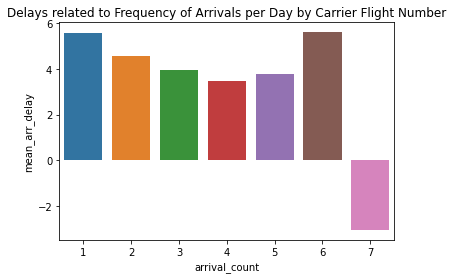

In [24]:
sns.barplot(x="arrival_count", y="mean_arr_delay", data=temp).set_title("Delays related to Frequency of Arrivals per Day by Carrier Flight Number")

In [35]:
carriers_flnum = carriers.groupby(["mkt_unique_carrier", "mkt_carrier_fl_num"], as_index=False)["arr_delay"].mean()

/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Mean Delays by mkt_carrier_fl_num ')

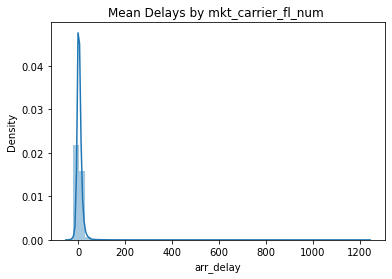

In [38]:
sns.distplot(carriers_flnum.arr_delay).set_title("Mean Delays by mkt_carrier_fl_num ")

In [43]:
carriers_flnum.sort_values(by="arr_delay", ascending = False).head(30)

,mkt_unique_carrier,mkt_carrier_fl_num,arr_delay
5903,AA,9378,1239.000000
18772,G4,1128,916.000000
5874,AA,9301,794.000000
5885,AA,9330,555.000000
17781,F9,7306,492.000000
20026,G4,2527,442.000000
32,AA,38,411.000000
5918,AA,9400,409.000000
5886,AA,9332,387.000000
5915,AA,9391,354.500000


> it doesn't appear that reccuring flight numbers cause significant problems for delays

***op_unique_carrier***

In [55]:
carrier_op = carriers.groupby(['mkt_unique_carrier',"op_unique_carrier"], as_index=False)["arr_delay"].mean()

Text(0.5, 1.0, 'Delays related to Operator Unique Carrier')

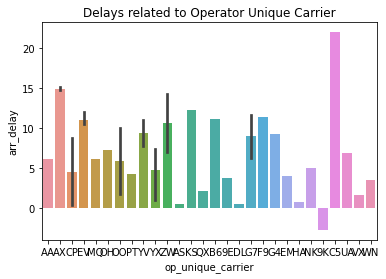

In [57]:
sns.barplot(x="op_unique_carrier", y="arr_delay", data=carrier_op).set_title("Delays related to Operator Unique Carrier")

***op_carrier_fl_num***

In [60]:
carriers.groupby(["op_unique_carrier",'mkt_carrier_fl_num', 'op_carrier_fl_num'])["arr_delay"].mean()

op_unique_carrier  mkt_carrier_fl_num  op_carrier_fl_num
9E                 3280                3280                   9.941176
                   3281                3281                   8.159420
                   3282                3282                   2.720000
                   3283                3283                   4.381526
                   3284                3284                   3.852590
                                                               ...    
ZW                 5829                3150                 488.000000
                   6020                3150                   3.000000
                   6104                3151                  19.000000
                   6107                3151                  37.000000
                   6270                3151                  29.000000
Name: arr_delay, Length: 36341, dtype: float64

In [64]:
len(carriers.groupby(["mkt_unique_carrier",'mkt_carrier_fl_num'])["arr_delay"].mean())

34190

In [65]:
len(carriers.groupby(["mkt_unique_carrier",'op_carrier_fl_num'])["arr_delay"].mean())

34278

In [69]:
carriers.mkt_unique_carrier.unique()

array(['WN', 'DL', 'AA', 'AS', 'UA', 'NK', 'B6', 'F9', 'HA', 'G4', 'VX'],
      dtype=object)

In [77]:
carriers_flnum = carriers.groupby(["mkt_unique_carrier", "op_unique_carrier"], as_index=False)["arr_delay"].mean()

In [81]:
carriers_flnum

,mkt_unique_carrier,op_unique_carrier,arr_delay
0,AA,AA,6.154631
1,AA,AX,14.767719
2,AA,CP,0.338263
3,AA,EV,10.472747
4,AA,MQ,6.060691
5,AA,OH,7.302339
6,AA,OO,9.899759
7,AA,PT,4.255860
8,AA,YV,11.045811
9,AA,YX,0.969016


---

Q: What *unique* information is provided in the origin and destination information?
<br>A: There are some cities with multiple airports

---

In [83]:
locations = df[['origin_airport_id', 'origin', 'origin_city_name',
       'dest_airport_id', 'dest', 'dest_city_name']]

In [84]:
locations.head()

,origin_airport_id,origin,origin_city_name,dest_airport_id,dest,dest_city_name
0,14679,SAN,"San Diego, CA",11259,DAL,"Dallas, TX"
1,10423,AUS,"Austin, TX",11433,DTW,"Detroit, MI"
2,10874,CAK,"Akron, OH",13930,ORD,"Chicago, IL"
3,13930,ORD,"Chicago, IL",15304,TPA,"Tampa, FL"
4,13487,MSP,"Minneapolis, MN",14747,SEA,"Seattle, WA"


In [87]:
len(locations.origin_airport_id.unique())

375

In [88]:
len(locations.dest_airport_id.unique())

375

In [89]:
len(locations.origin.unique())

375

In [90]:
len(locations.dest.unique())

375

In [91]:
len(locations.origin_city_name.unique())

367

In [92]:
len(locations.dest_city_name.unique())

367

>it is evident that the origin and origin airports are unique <br> but the city names are not unique there are 8 airports that are not related to unique cities

In [114]:
origins = locations.groupby(["origin_city_name", "origin_airport_id"], as_index=False)["origin"].count()

In [115]:
origins = origins.groupby("origin_city_name")["origin_airport_id"].count()

In [119]:
origins.sort_values().tail(10)

origin_city_name
Grand Junction, CO    1
Yuma, AZ              1
Washington, DC        2
Phoenix, AZ           2
Houston, TX           2
Columbus, OH          2
Mobile, AL            2
Williston, ND         2
New York, NY          2
Chicago, IL           2
Name: origin_airport_id, dtype: int64

duplicate cities 
> Washington, DC     
<br>Phoenix, AZ           
<br>Houston, TX           
<br>Columbus, OH          
<br>Mobile, AL            
<br>Williston, ND         
<br>New York, NY          
<br>Chicago, IL           

In [121]:
#spot check NY
locations[locations.origin_city_name == "New York, NY"].head()

,origin_airport_id,origin,origin_city_name,dest_airport_id,dest,dest_city_name
24,12953,LGA,"New York, NY",11057,CLT,"Charlotte, NC"
33,12478,JFK,"New York, NY",14492,RDU,"Raleigh/Durham, NC"
46,12478,JFK,"New York, NY",14576,ROC,"Rochester, NY"
59,12478,JFK,"New York, NY",14831,SJC,"San Jose, CA"
77,12478,JFK,"New York, NY",13930,ORD,"Chicago, IL"


> makes sense because you have both JFK and Ligardia

---

Q: What is dup
<br> A: Not relevant

---

In [122]:
dup = df[["dup", "arr_delay"]]

In [124]:
dup.dup.unique()

array(['N'], dtype=object)

---

Q: What is flights
<br>A: Not useful

---

In [125]:
flights = df[["flights","arr_time"]]

In [126]:
flights.flights.unique()

array([1.])

---

Q: How does haul length impact the delay
<br> A:

---

In [162]:
def define_haul_length(distance):
    """Determine the haul length of a given distance
    INPUT distance (in miles)
    RETURNS {0: short haul, 1: medium haul, 2: long haul}"""
    
    if distance < 600:
        return 0 
    elif distance < 1500:
        return 1
    else: 
        return 2

In [163]:
haul = df[["distance","fl_date", "arr_delay"]]

In [164]:
haul["haul_len"] = haul["distance"].map(define_haul_length)

<ipython-input-164-efd4f8fc829c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  haul["haul_len"] = haul["distance"].map(define_haul_length)


In [156]:
haul.head()

,distance,fl_date,arr_delay,haul_len
0,1182.0,2018-10-04,-8.0,1
1,1149.0,2019-02-18,-43.0,1
2,343.0,2019-08-21,13.0,0
3,1011.0,2019-08-29,-7.0,1
4,1399.0,2018-02-12,7.0,1


In [165]:
temp = haul.groupby(["haul_len","fl_date"],as_index=False)["arr_delay"].mean().sort_values(by = "arr_delay", ascending=False)

Text(0.5, 1.0, 'Delay by haul length')

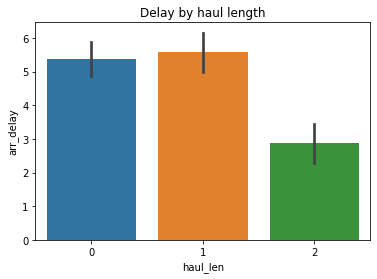

In [166]:
sns.barplot(x="haul_len", y="arr_delay", data=temp).set_title("Delay by haul length")

In [167]:
len(haul[haul.haul_len == 0])

2479553

In [168]:
len(haul[haul.haul_len == 1])

1952846

In [169]:
len(haul[haul.haul_len == 1])

1952846

***Check Percent Cancelled***

In [170]:
df["cancelled"]

0          0.0
1          0.0
2          0.0
3          0.0
4          0.0
          ... 
4999995    0.0
4999996    0.0
4999997    0.0
4999998    0.0
4999999    0.0
Name: cancelled, Length: 5000000, dtype: float64

In [172]:
len(df[df["cancelled"]==1])

85067

In [174]:
len(df)

5000000

In [177]:
len(df[df["cancelled"]==1])/len(df)*100

1.70134

---

***Flight Num Revisited***

A number of conventions have been developed for defining flight numbers, although these vary widely from airline to airline, and are increasingly being modified. Eastbound and northbound flights are traditionally assigned even numbers, while westbound and southbound flights have odd numbers. Other airlines will use an odd number for an outbound flight and use the next even number for the reverse inbound flight. For destinations served by multiple flights per day, numbers tend to increase during the day. Hence, a flight from point A to point B might be flight 101 and the return flight from B to A would be 102, while the next pair of flights on the same route would usually be assigned codes 103 and 104.

Flight numbers of less than three digits are often assigned to long-haul or otherwise premium flights. For example, flight number 1 is often used for an airline's "flagship" service (see below for a ‘List of flight number 1 by airlines’).

Four-digit numbers in the range 3000 to 5999 typically represent regional affiliate flights, while numbers larger than 6000 are generally codeshare numbers for flights operated by different airlines or even railways.

Likewise, flight numbers larger than 9000 usually refer to ferry flights; these carry no passengers and are used to relocate aircraft to or from a maintenance base, or from one air travel market to another in order to start new commercial flights. Flight numbers starting with 8 are often used for charter flights, but it always depends on the commercial carrier's choice. United, for example, usually uses flight numbers 2500-2599 as either cargo or charter flights. [link](https://en.wikipedia.org/wiki/Flight_number)

In [196]:
flightnums = df[df.cancelled == 0]
flightnums = df[["mkt_carrier_fl_num", "op_carrier_fl_num", "arr_delay"]]

In [188]:
def flight_type(fl_num):
    """Takes in a fl_num and returns the type of flight
        INPUT fl_num
        RETURNs flight_type 
                0 : premium, 1 : regular, 2 : regional, ferry, codeshare"""
    fl_num = str(fl_num)
    if len(fl_num) < 3:
        return 0 #preimum
    if len(fl_num) == 3:
        return 1 #reg
    else: 
        return 2 #regional affiliate, ferry, codeshare, etc.

In [197]:
flightnums["mkt_flight_type"] = flightnums["mkt_carrier_fl_num"].map(flight_type)
flightnums["op_flight_type"] = flightnums["op_carrier_fl_num"].map(flight_type)

<ipython-input-197-4473a0a6be7f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  flightnums["mkt_flight_type"] = flightnums["mkt_carrier_fl_num"].map(flight_type)
<ipython-input-197-4473a0a6be7f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  flightnums["op_flight_type"] = flightnums["op_carrier_fl_num"].map(flight_type)


In [198]:
flightnums.groupby("mkt_flight_type")["arr_delay"].mean()

mkt_flight_type
0    3.447512
1    4.338777
2    5.708284
Name: arr_delay, dtype: float64

In [199]:
flightnums.groupby("mkt_flight_type")["arr_delay"].count()

mkt_flight_type
0      88516
1    1041356
2    3870128
Name: arr_delay, dtype: int64

In [200]:
flightnums.groupby("op_flight_type")["arr_delay"].mean()

op_flight_type
0    3.447512
1    4.338772
2    5.708286
Name: arr_delay, dtype: float64

In [ ]:
flightnums.groupby("op_flight_type")["arr_delay"].mean()

In [203]:
len(df.tail_num.unique())

6471